In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# import

In [13]:
import sys 
sys.path.append("..") 
#from exp import nb_bbox_hw_statistics
from detect_symbol.exp import nb_databunch
from detect_symbol.exp import nb_resnet_ssd
from detect_symbol.exp import nb_init_model

In [14]:
# export
import torch

In [15]:
# export
from torch.nn import functional as F

In [16]:
# export
from torch import tensor

In [17]:
from matplotlib import pyplot as plt

In [18]:
# export
from IPython.core import debugger as idb

In [19]:
# export
import numpy as np

In [20]:
# export
import math

# config

# anchors

## 说明

**怎样设置anchor？**  
  
- 在detet_symbol项目中，我们对数据的统计特征比较清晰，也可以确定测试数据与训练数据的统计特征比较一致。所以可以根据训练数据的统计特征来确定anchor设置，而不用过于担心泛化问题。
- 据此，关于anchor的设置可根据 bbox_hw_statistics.ipynb 的分析来确定，此处不赘述。

### 无zoom

**怎样设置grid？**  
  
1. 根据 bbox_hw_statistics.ipynb 的分析，x方向上的最近距离是52.5，y方向上的最近距离是22. 但在模型的设计中，各层（卷积、池化）的 kernel_size 和 stride 等都在两个方向上一致，所以特征图的 stride 在两个方向应是一样的。所以应取更严格的条件，即特征图的stride（在x和y方向上都）应小于22.
2. 特征图的stride一般都是 $2^n$ 的形式，又其应小于22，所以我们可以取最小 stride=16.
3. 利用 receptive_field.ipynb 分析模型各层特征图的几何信息，并据此选择由哪些特征层来预测，以及各层负责哪些 anchor. 我们以resnet18为例。
    1. 其 `layer3.1.conv2` 层 stride=16，receptive=211. 我们选择由该层负责（17,22）、（36,22）、（17,43）、（36,43）四个 anchor. 则 anchor 最大尺寸 43 约占 receptive=211 的 1/5.
    2. 其 `layer4.1.conv2` 层 stride=32, receptive=435. 我们选择由该层负责（77,43）、（36,83）、（77,83）三个 anchor. 其 anchor 最大尺寸 83 同样约占 receptive=435 的 1/5.
    3. 虽然 resnet18 没有更深的层，但是我们可以自己继续添加。假如添加至 `layer5.1.conv2` 层，其 stride=64，receptive 应约为 900，我们可以由该层负责（162,83）、（77,161）、（162,161）三个 anchor. 其 anchor 最大尺寸 162 也是约占 receptive=900 的 1/5.
4. 因为我们已经确定了特征图的stride，则特征图的尺寸就由输入图片尺寸来决定。
    - 特征图尺寸通常选择奇数，这样中心位置处恰有一个grid负责。
    - 还要注意，在我们的detect_symbol项目中，训练图片尺寸不能太小。因为我们是从少量几张大图纸中随机截取大量小图片作为训练数据，而且若所截取图片中的目标不完整则抹掉该目标，所以截取的图片越小，则它能包含大目标（根据 bbox_hw_statistics.ipynb 的统计，最大目标尺寸约235）的概率就越小。
    - 据此考虑，我们选择三个特征图尺寸分别为49、25、13. 则输入图片尺寸应为 49x16=784. 

### zoom [0.5,2], (20200426)

**怎样设置grid？**  
  
1. 根据 bbox_hw_statistics.ipynb 的分析，x方向上的最近距离是25，y方向上的最近距离是10.5. 但在模型的设计中，各层（卷积、池化）的 kernel_size 和 stride 等都在两个方向上一致，所以特征图的 stride 在两个方向应是一样的。所以应取更严格的条件，即特征图的stride（在x和y方向上都）应小于10.5.
2. 特征图的stride一般都是 $2^n$ 的形式，又其应小于10.5，所以我们可以取最小 stride=8. 
3. 利用 receptive_field.ipynb 分析模型各层特征图的几何信息，并据此选择由哪些特征层来预测，以及各层负责哪些 anchor. 我们以resnet18为例。
    1. 其 `layer2.1.conv2` 层 stride=8，receptive=99. 我们选择由该层负责（10,13）、(10,34)、（30,13）、（30,34）四个 anchor. 则 anchor 最大尺寸 34 约占 receptive=99 的 1/3.
    2. 其 `layer3.1.conv2` 层 stride=16, receptive=211. 我们选择由该层负责（10,92）、（30,92）、（87,92）、(87,13)、(87,34)五个 anchor. 其 anchor 最大尺寸 92 同样约占 receptive=211 的 1/2.
    3. 其 `layer4.1.conv2` 层 stride=32, receptive=435. 我们选择由该层负责（30,244）、（87,244）、（254,244）、（254,35）、（254,92）五个 anchor. 其 anchor 最大尺寸 244 同样约占 receptive=435 的 1/2.
4. 因为我们已经确定了特征图的stride，则特征图的尺寸就由输入图片尺寸来决定。
    - 特征图尺寸通常选择奇数，这样中心位置处恰有一个grid负责。
    - 还要注意，在我们的detect_symbol项目中，训练图片尺寸不能太小。因为我们是从少量几张大图纸中随机截取大量小图片作为训练数据，而且若所截取图片中的目标不完整则抹掉该目标，所以截取的图片越小，则它能包含大目标（根据 bbox_hw_statistics.ipynb 的统计，最大目标尺寸约235）的概率就越小。
    - 据此考虑，我们选择三个特征图尺寸分别为97、49、25. 则输入图片尺寸应为 97x8=776. 

### 20200429

**怎样设置grid？**  
  
1. 根据 bbox_hw_statistics.ipynb 的分析，x方向上的最近距离是25，y方向上的最近距离是10.5. 但在模型的设计中，各层（卷积、池化）的 kernel_size 和 stride 等都在两个方向上一致，所以特征图的 stride 在两个方向应是一样的。所以应取更严格的条件，即特征图的stride（在x和y方向上都）应小于10.5.
2. 特征图的stride一般都是 $2^n$ 的形式，又其应小于10.5，所以我们可以取最小 stride=8. 
3. 利用 receptive_field.ipynb 分析模型各层特征图的几何信息，并据此选择由哪些特征层来预测，以及各层负责哪些 anchor. 我们以resnet34为例。
    1. 其 `layer2.3.conv2` 层 stride=8，receptive=179. 我们选择由该层负责（10,13）、(10,34)、（30,13）、（30,34）四个 anchor. 则 anchor 最大尺寸 34 约占 receptive=179 的 1/5.3.
    2. 其 `layer3.5.conv2` 层 stride=16, receptive=547. 我们选择由该层负责（10,92）、（30,92）、（87,92）、(87,13)、(87,34)五个 anchor. 其 anchor 最大尺寸 92 同样约占 receptive=547 的 1/5.9.
    3. 其 `layer4.2.conv2` 层 stride=32, receptive=899. 我们选择由该层负责（30,244）、（87,244）、（254,244）、（254,35）、（254,92）五个 anchor. 其 anchor 最大尺寸 254 同样约占 receptive=899 的 1/3.5.
4. 因为我们已经确定了特征图的stride，则特征图的尺寸就由输入图片尺寸来决定。
    - 特征图尺寸通常选择奇数，这样中心位置处恰有一个grid负责。
    - 还要注意，在我们的detect_symbol项目中，训练图片尺寸不能太小。因为我们是从少量几张大图纸中随机截取大量小图片作为训练数据，而且若所截取图片中的目标不完整则抹掉该目标，所以截取的图片越小，则它能包含大目标（根据 bbox_hw_statistics.ipynb 的统计，最大目标尺寸约235）的概率就越小。
    - 据此考虑，我们选择三个特征图尺寸分别为97、49、25. 则输入图片尺寸应为 97x8=776. 

## functions

In [10]:
# export
def get_grids_anchors(fig_hw, grids, anchors):
    import pdb; pdb.set_trace()
    fig_h,fig_w = fig_hw
    anchors = [[(ah/fig_h, aw/fig_w) for (ah,aw) in ancs] for ancs in anchors]
    gridCnrs_ancCnrs = tensor([[x/gx, y/gy, (x+1)/gx, (y+1)/gy,
                                -ax/2, -ay/2, ax/2, ay/2]
                                for (gx,gy),ancs in zip(grids,anchors)
                                for y in range(gy)
                                for x in range(gx)
                                for ax,ay in ancs])
    
    # grid corners, (use v to represent corners)
    gvs = gridCnrs_ancCnrs[:,:4]
    
    # grid heights and widths
    ghs = gvs[:,2] - gvs[:,0]
    gws = gvs[:,3] - gvs[:,1]
    
    # anchor corners
    avs = gridCnrs_ancCnrs[:,4:]
    
    # anchor heights and widthds
    ahs = avs[:,2] - avs[:,0]
    aws = avs[:,3] - avs[:,1]
    
    return gvs,ghs,gws,avs,ahs,aws

In [39]:
#获取某个idx的anchor的周围anchor的idx列表。距离默认1
#排列方式是先y后x，每个xy重复一下anchors的数量
def find_neibs(idx, fig_hw, grids, anchors, dis = 1):
    fig_h,fig_w = fig_hw
    #anchors = [[(ah/fig_h, aw/fig_w) for (ah,aw) in ancs] for ancs in anchors]
    #直接按照get_grids_anchors生成的方式生成一遍每个对应的xy坐标和所在grid就行了。
    gridCnrs_ancCnrs = [[x, y, gx, gy, ax, ay]
                                for (gx,gy),ancs in zip(grids,anchors)
                                for y in range(gy)
                                for x in range(gx)
                                for ax,ay in ancs]
    assert idx < len(gridCnrs_ancCnrs)
    x, y, gx, gy, ax, ay = gridCnrs_ancCnrs[idx]
    neibs = [(nx, ny, gx, gy, ax, ay) for nx in range(x - dis, x + dis + 1) 
                         for ny in range(y - dis, y + dis + 1) 
                             if nx >= 0 and ny >= 0]
    print(neibs, x, y, gx, gy, ax, ay)
    ret = []
    for i in range(len(gridCnrs_ancCnrs)):
        x, y, gx, gy, ax, ay = gridCnrs_ancCnrs[i]
        for n in neibs:
            if n[0] == x and n[1] == y and n[2] == gx and n[3] == gy:#[x, y, gx, gy, ax, ay]:
                #if operator.eq(n, neibs):
                ret += [i]
    print('r', ret)
    for r in ret:
        print(gridCnrs_ancCnrs[r])
    return ret
    
fig_hw = (784,784)
grids = [(49,49),(25,25),(13,13)]
anchors = [[(22,17),(22,37),(43,17),(43,37)],
           [(43,77),(83,37),(83,77)],
           [(83,162),(162,77),(162,162)]]
find_neibs(100, fig_hw, grids, anchors)

[(24, 0, 49, 49, 22, 17), (24, 1, 49, 49, 22, 17), (25, 0, 49, 49, 22, 17), (25, 1, 49, 49, 22, 17), (26, 0, 49, 49, 22, 17), (26, 1, 49, 49, 22, 17)] 25 0 49 49 22 17
r [96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303]
[24, 0, 49, 49, 22, 17]
[24, 0, 49, 49, 22, 37]
[24, 0, 49, 49, 43, 17]
[24, 0, 49, 49, 43, 37]
[25, 0, 49, 49, 22, 17]
[25, 0, 49, 49, 22, 37]
[25, 0, 49, 49, 43, 17]
[25, 0, 49, 49, 43, 37]
[26, 0, 49, 49, 22, 17]
[26, 0, 49, 49, 22, 37]
[26, 0, 49, 49, 43, 17]
[26, 0, 49, 49, 43, 37]
[24, 1, 49, 49, 22, 17]
[24, 1, 49, 49, 22, 37]
[24, 1, 49, 49, 43, 17]
[24, 1, 49, 49, 43, 37]
[25, 1, 49, 49, 22, 17]
[25, 1, 49, 49, 22, 37]
[25, 1, 49, 49, 43, 17]
[25, 1, 49, 49, 43, 37]
[26, 1, 49, 49, 22, 17]
[26, 1, 49, 49, 22, 37]
[26, 1, 49, 49, 43, 17]
[26, 1, 49, 49, 43, 37]


[96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303]

## test

In [21]:
#距离之间的事情可以不考虑？先按照resnet18来一个
# 获取 grids 和 anchors
gvs,ghs,gws,avs,ahs,aws = get_grids_anchors(fig_hw = (776,776),
                                            grids = [(49,49)],
                                            anchors = [[(22,17)]])

> <ipython-input-10-b13624ddaa14>(4)get_grids_anchors()
-> fig_h,fig_w = fig_hw
(Pdb) c


In [29]:
# fig_hw = (784,784)
# grids = [(49,49),(25,25),(13,13)]
# anchors = [[(22,17),(22,37),(43,17),(43,37)],
#                                          [(43,77),(83,37),(83,77)],
#                                          [(83,162),(162,77),(162,162)]]
#for (gx,gy),ancs in zip(grids,anchors) : 
#        print(gx,gy,ancs)
        
#at = [[gx, gy, ancs, y, x]  for (gx,gy),ancs in zip(grids,anchors) for y in range(gy) for x in range(gx)]    
#print(at)

In [30]:
# 这些变量的尺寸
gvs.shape, ghs.shape, gws.shape, avs.shape, ahs.shape, aws.shape

(torch.Size([2401, 4]),
 torch.Size([2401]),
 torch.Size([2401]),
 torch.Size([2401, 4]),
 torch.Size([2401]),
 torch.Size([2401]))

In [31]:
# 为什么有这样的尺寸
#49*49*4+25*25*3+13*13*3

In [34]:
49*49*1  #只有一个anchor

2401

## zip as function

In [26]:

# # 此函数仅为方便其它测试的调用
# def get_ga433():
#     return get_grids_anchors(fig_hw = (784,784),
#                               grids = [(49,49),(25,25),(13,13)],
#                               anchors = [[(22,17),(22,37),(43,17),(43,37)],
#                                          [(43,77),(83,37),(83,77)],
#                                          [(83,162),(162,77),(162,162)]])

In [27]:

# def get_ga444():
#     return get_grids_anchors(fig_hw = (784,784),
#                               grids = [(49,49),(25,25),(13,13)],
#                               anchors = [[(22,17),(22,37),(43,17),(43,37)],
#                                          [(43,37),(43,77),(83,37),(83,77)],
#                                          [(83,77),(83,162),(162,77),(162,162)]])

In [28]:

# def get_ga666():
#     return get_grids_anchors(fig_hw = (776,776),
#                               grids = [(97,97),(49,49),(25,25)],
#                               anchors = [[( 34, 3),( 34,10),( 34, 30),(13, 30),( 5, 30),(13,10)],
#                                          [( 92,10),( 92,30),( 92, 87),(35, 87),(13, 87),(34,30)],
#                                          [(244,30),(244,87),(244,254),(92,254),(35,254),(92,87)]])

In [35]:
# export
def get_ga1():
    return get_grids_anchors(fig_hw = (776,776), grids = [(49,49)]
                             , anchors = [[(1,1)]])

# loss

## functions

### test_getIdx

In [36]:
test_ahws = [(22,17),(22,37),(43,17),(43,37),
             (43,77),(83,37),(83,77),
             (83,162),(162,77),(162,162)]
test_ahs = tensor([a[0]/784 for a in test_ahws])
test_aws = tensor([a[1]/784 for a in test_ahws])
test_abbs = tensor([[-ah/2,-aw/2,ah/2,aw/2] for (ah,aw) in zip(test_ahs,test_aws)])

def test_getIdx(bb):
    # bb中心
    cx = bb[[0,2]].mean()
    cy = bb[[1,3]].mean()
     
    # bb去中心偏移
    bb[[0,2]] = bb[[0,2]] - cx
    bb[[1,3]] = bb[[1,3]] - cy
    
    scores = iou(bb[None],test_abbs)
    idxa = scores.max(0)[1] # idxa: index of anchor
    
    if idxa in [0,1,2,3]: 
        offset = 0
        nanc = 4
        g = 49
    elif idxa in [4,5,6]: 
        offset = 49*49*4
        idxa -= 4
        nanc = 3
        g = 25
    elif idxa in [7,8,9]: 
        offset = 49*49*4 + 25*25*3
        idxa -= 7
        nanc = 3
        g = 13

    idxx = int(cx*g)
    idxy = int(cy*g)
    idx = offset + (idxy*g+idxx)*nanc+idxa
    
    return idx

### bbox $\leftrightarrow$ prediction: b2t, t2b

$b_x=\hat{\sigma}\left(t_x\right)\cdot g_w+c_x$  
$b_y=\hat{\sigma}\left(t_y\right)\cdot g_h+c_y$  
$b_h=p_h\cdot e^{t_h}$  
$b_w=p_w\cdot e^{t_w}$  


where:  
- $\hat{\sigma}=(1+\epsilon)\cdot(\sigma-0.5)+0.5$，and $\epsilon$ is a small positive number.
- $t_x,t_y,t_w,t_h$ are predictions made by model.  
- $c_x,c_y$ is the top left corner of the grid cell of the anchor.  
- $g_h,g_w$ are the height and width of the grid cell.
- $p_h,p_w$ are the height and width of the anchor.
- $c_x,c_y,p_h,p_w,g_h,g_w$ are normalized by the image height and width.
- $b_x,b_y,b_w,b_h$ are the center x and y, the width and height of predicted boundary box.

下面绘出 $\hat{\sigma}$ 曲线：

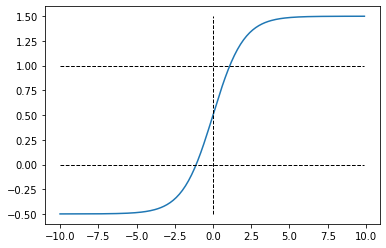

In [39]:
# 绘制 hat{sigma}
eta = 1

xxx = tensor(range(-100,100)).float()/10
yyy = (1+eta)*(torch.sigmoid(xxx)-0.5) + 0.5

plt.plot(xxx,yyy);
plt.plot(xxx,torch.zeros(len(xxx)),'k--',linewidth=1);
plt.plot(xxx,torch.zeros(len(xxx))+1,'k--',linewidth=1);
plt.plot(torch.zeros(len(yyy)),yyy,'k--',linewidth=1)

#### t2b

In [ ]:
# export
def t2b(t,idx,eps=1):
    cx,cy = gvs[idx,0],gvs[idx,1]
    gh,gw = ghs[idx],gws[idx]
    ph,pw = ahs[idx],aws[idx]
    
    sig_tx = torch.sigmoid(t[:,0])
    sig_ty = torch.sigmoid(t[:,1])
    exp_th = torch.exp(t[:,2])
    exp_tw = torch.exp(t[:,3])
    
    hatsig_tx = (1+eps)*(sig_tx-0.5) + 0.5
    hatsig_ty = (1+eps)*(sig_ty-0.5) + 0.5
    
    bx = hatsig_tx*gw + cx # x of center of box
    by = hatsig_ty*gh + cy # y of center of box
    
    bh = ph * exp_th    # height of box
    bw = pw * exp_tw    # width of box
    
    tl_x = bx - bh/2 # x of top-left corner of box
    tl_y = by - bw/2 # y of top-left corner of box 
    br_x = bx + bh/2 # x of bottom-right corner of box
    br_y = by + bw/2 # y of bottom-right corner of box
    
    return torch.stack([tl_x, tl_y, br_x, br_y]).t()

#### b2t

**math of b2t:**  
  
$\hat{\sigma}(t_x)=(b_x-c_x)/g_h$  
$\hat{\sigma}(t_y)=(b_y-c_y)/g_w$   
$e^{t_x}=b_h/p_h$  
$e^{t_y}=b_w/p_w$  
  
$\sigma(t_x)=\frac{\hat{\sigma}(t_x)-0.5}{1+\epsilon}+0.5=\frac{\hat{\sigma}(t_x)-0.5+0.5+0.5\cdot\epsilon}{1+\epsilon}=\frac{\hat{\sigma}(t_x)+0.5\cdot\epsilon}{1+\epsilon}$  
$\sigma(t_y)=\frac{\hat{\sigma}(t_y)-0.5}{1+\epsilon}+0.5=\frac{\hat{\sigma}(t_y)-0.5+0.5+0.5\cdot\epsilon}{1+\epsilon}=\frac{\hat{\sigma}(t_y)+0.5\cdot\epsilon}{1+\epsilon}$  
  
$\sigma(t_x)=\frac{1}{1+e^{-t_x}}\Rightarrow e^{-t_x}=\frac{1}{\sigma(t_x)}-1=\frac{1-\sigma(t_x)}{\sigma(t_x)}\Rightarrow e^{t_x}=\frac{\sigma(t_x)}{1-\sigma(t_x)}\Rightarrow$    
  
$t_x=\log(\frac{\sigma(t_x)}{1-\sigma(t_x)})$  
$t_y=\log(\frac{\sigma(t_y)}{1-\sigma(t_y)})$

In [ ]:
# export
def b2t(b,idx,eps=1):
    cx,cy = gvs[idx,0],gvs[idx,1]
    gh,gw = ghs[idx],gws[idx]
    ph,pw = ahs[idx],aws[idx]
    
    bx = (b[:,0] + b[:,2])/2 # x of center of box
    by = (b[:,1] + b[:,3])/2 # y of center of box
    bh = b[:,2] - b[:,0]     # height of box
    bw = b[:,3] - b[:,1]     # width of box
    
    hatsig_tx = (bx - cx)/gh
    hatsig_ty = (by - cy)/gw
    exp_th = bh / ph
    exp_tw = bw / pw
    
    sig_tx = (hatsig_tx+0.5*eps)/(1+eps)
    sig_ty = (hatsig_ty+0.5*eps)/(1+eps)
    
    tx = torch.log(sig_tx/(1-sig_tx))
    ty = torch.log(sig_ty/(1-sig_ty))
    th = torch.log(exp_th)
    tw = torch.log(exp_tw)
    
    return torch.stack([tx, ty, th, tw]).t()

### bbox $\leftrightarrow$ cent, h, w: bbox2chw

In [ ]:
# export
def bbox2chw(b):
    '''
    将bbox的（左上x，左上y，右下x，右下y）表示变为（中心x，中心y，高，宽）表示
    '''
    cx = b[...,[0,2]].mean(-1)[...,None]
    cy = b[...,[1,3]].mean(-1)[...,None]
    
    h = (b[...,2]-b[:,0])[...,None]
    w = (b[...,3]-b[:,1])[...,None]
    
    return torch.cat([cx,cy,h,w],dim=-1)

### get_y

In [ ]:
# export
def get_y(bboxs):
    bboxs = bboxs.view(-1,4)
    keep = bboxs.abs().sum(-1).nonzero()[:,0]
    return keep

### iou

In [ ]:
# export
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[..., 2:], box_b[..., 2:])
    min_xy = torch.max(box_a[..., :2], box_b[..., :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[..., 0] * inter[..., 1]

def box_sz(b): return ((b[..., 2]-b[..., 0]) * (b[..., 3]-b[..., 1]))

def iou(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a) + box_sz(box_b) - inter
    return inter / union

### get_scores_hits

In [ ]:
# export
def get_scores_hits(gt_bboxs): 
    # ground truch bbox center x,y
    gt_cx = gt_bboxs[:,[0,2]].mean(-1)
    gt_cy = gt_bboxs[:,[1,3]].mean(-1)
    
    # find the center where the anchors will be shifted at.    
    anc_cx = (gt_cx[:,None]<gvs[:,0]).float() * (gvs[:,0]-gt_cx[:,None]) + \
             (gt_cx[:,None]>gvs[:,2]).float() * (gvs[:,2]-gt_cx[:,None]) + \
              gt_cx[:,None];
    anc_cy = (gt_cy[:,None]<gvs[:,1]).float() * (gvs[:,1]-gt_cy[:,None]) + \
             (gt_cy[:,None]>gvs[:,3]).float() * (gvs[:,3]-gt_cy[:,None]) + \
              gt_cy[:,None];

    # shift anchors at center (anc_cx, anc_cy)
    # fxdAncCnrs: fixed anchor corners
    fxdAncVs = avs + torch.cat([anc_cx[...,None], anc_cy[...,None]],dim=-1).repeat(1,1,2)

    # 匹配度得分
    scores = iou(gt_bboxs[:,None,:], fxdAncVs)
    
    # 判断目标bbox的中心落在哪个cell内
    hits = ((gt_cx[:,None] >= gvs[:,0][None]) &
            (gt_cx[:,None] <  gvs[:,2][None]) &
            (gt_cy[:,None] >= gvs[:,1][None]) &
            (gt_cy[:,None] <  gvs[:,3][None]))

    return scores,hits

### idx_fromScoresHits

In [ ]:
# export
def idx_fromScoresHits(scores,hits):
    idx = (scores*hits.float()).max(1)[1]
    return idx

### get_clasWeights

In [ ]:
# export
def get_clasWeights(clas_cnts=[], max_imblance=5):
    if max_imblance<=1: 
        max_imblance = 1.01
    
    clas_cnts = np.array(clas_cnts)
    N = len(clas_cnts)
    minCnt = min(clas_cnts)
    maxCnt = max(clas_cnts)
    
    eta = (maxCnt-minCnt*max_imblance)/(max_imblance-1)
    eta = max(eta,0)
    
    expect_cnts = clas_cnts + eta
    weights = expect_cnts/clas_cnts
    weights = weights * N / weights.sum()
    
    return weights

### class loss

**若某anchor对某object负责，则应训练其classification靠近该object的类别。**

In [ ]:
# export
def clas_L(pred_batch, *gt_batch, lambda_clas=1, clas_weights=None, gaf):
    loss = 0
    cnt = 0
    for pred_clas,gt_bboxs,gt_clas in zip(pred_batch[2], *gt_batch):
        keep = get_y(gt_bboxs)
        if keep.numel()==0: continue
        
        gt_bboxs = gt_bboxs[keep]
        gt_clas = gt_clas[keep]
        
        gt_bboxs = (gt_bboxs + 1) / 2
        gt_clas = gt_clas - 1 # the databunch add a 'background' class to classes[0], but we don't want that,so gt_clas-1
        
        scores,hits = gaf.get_scores_hits(gt_bboxs)
        idx = idx_fromScoresHits(scores,hits)
        
        pred_clas = pred_clas[idx]
        
        loss += F.cross_entropy(pred_clas, gt_clas, weight=clas_weights, reduction='sum')
        cnt += gt_clas.shape[0]
        
    return lambda_clas*loss/cnt

### bbox center loss

**若某 anchor 对某 object 负责，则应训练其预测之 中心 靠近该 object box 之 中心。**

In [ ]:
# export
def cent_L(pred_batch, *gt_batch, lambda_cent=1, clas_weights=None, gaf):
    loss = 0
    cnt = 0
    for pred_txy,gt_bboxs,gt_clas in zip(pred_batch[0], *gt_batch):
        keep = get_y(gt_bboxs)
        if keep.numel()==0: continue
          
        gt_bboxs = gt_bboxs[keep]
        gt_clas = gt_clas[keep]
        
        gt_bboxs = (gt_bboxs + 1) / 2
        gt_clas = gt_clas - 1
        
        if clas_weights is not None: ws = clas_weights[gt_clas]
        else: ws = None
        
        scores,hits = gaf.get_scores_hits(gt_bboxs)
        idx = idx_fromScoresHits(scores,hits)
        
        gt_t = gaf.b2t(gt_bboxs,idx,eps=1)
        pred_txy = pred_txy[idx]
        
        if ws is not None:
            tmp = ((gt_t[...,:2]-pred_txy)*ws[...,None]).abs().sum()
        else:
            tmp = (gt_t[...,:2]-pred_txy).abs().sum()
        
        loss += tmp
        cnt += len(idx)
    
    return lambda_cent*loss/cnt

### positive confidence loss

**若某 anchor 为某 object 负责，则训练其 conf_score 靠近 1。**

In [ ]:
# export
def pConf_L(pred_batch, *gt_batch, lambda_pconf=1, clas_weights=None, gaf):
    loss = 0
    cnt = 0
    for pred_conf,gt_bboxs,gt_clas in zip(pred_batch[1], *gt_batch):
        keep = get_y(gt_bboxs)
        if keep.numel()==0: continue
          
        gt_bboxs = gt_bboxs[keep]
        gt_clas = gt_clas[keep]
        
        gt_bboxs = (gt_bboxs + 1) / 2
        gt_clas = gt_clas - 1
        
        if clas_weights is not None: ws = clas_weights[gt_clas]
        else: ws = None
        
        scores,hits = gaf.get_scores_hits(gt_bboxs)
        idx = idx_fromScoresHits(scores,hits)
        
        conf_pos = pred_conf[idx]
#         conf_pos = torch.sigmoid(conf_pos)
#         tmp = (1-conf_pos).abs().sum()
        if ws is not None: 
            tmp = F.binary_cross_entropy_with_logits(conf_pos,torch.ones_like(conf_pos),weight=ws[...,None],reduction='sum')
        else: 
            tmp = F.binary_cross_entropy_with_logits(conf_pos,torch.ones_like(conf_pos),reduction='sum')
    
    
        loss += tmp
        cnt += len(idx)
        
    return lambda_pconf*loss/cnt

### negative confidence loss

**若某 anchor 不对任何 object 负责，且它与任何 object 的 匹配得分 都差于 threshold，则训练其 conf_score 靠近 0。**

In [ ]:
# export
def nConf_L(pred_batch, *gt_batch, gaf, conf_th=0.5, lambda_nconf=1):
    loss = 0
    cnt = 0
    for pred_conf,gt_bboxs,_ in zip(pred_batch[1], *gt_batch):
        keep = get_y(gt_bboxs)
        if keep.numel()==0: continue
        
        gt_bboxs = gt_bboxs[keep]
        gt_bboxs = (gt_bboxs + 1) / 2
        
        scores,hits = gaf.get_scores_hits(gt_bboxs)
        idx = idx_fromScoresHits(scores,hits)
        
        scores[range(0,len(idx)),idx] = conf_th + 1 # 强制责任anchor的得分好于threshold
        tmp = scores>conf_th # 判断各得分是否好于threshold
        tmp = tmp.max(dim=0)[0] # 各anchor是否有任意一个好于threshold的得分
        neg_idx = torch.where(tmp==0)[0] # 如果没有，该anchor是negative anchor
        
        conf_neg = pred_conf[neg_idx]
#         conf_neg = torch.sigmoid(conf_neg)
#         loss += conf_neg.abs().sum()
        tmp = F.binary_cross_entropy_with_logits(conf_neg,torch.zeros_like(conf_neg),reduction='sum')
        loss += tmp
        cnt += len(neg_idx)
        
    return lambda_nconf*loss/cnt

### bbox height and width loss

**若某 anchor 对某 object 负责，则应训练其预测之 高与宽 靠近该 object box 之 高与宽。**

In [ ]:
# export
def hw_L(pred_batch, *gt_batch, gaf, lambda_hw=1, clas_weights=None):
    loss = 0
    cnt = 0
    for pred_thw,gt_bboxs,gt_clas in zip(pred_batch[3], *gt_batch):
        keep = get_y(gt_bboxs)
        if keep.numel()==0: continue
          
        gt_bboxs = gt_bboxs[keep]
        gt_clas = gt_clas[keep]
        
        gt_bboxs = (gt_bboxs + 1) / 2
        gt_clas = gt_clas - 1
        
        if clas_weights is not None: ws = clas_weights[gt_clas]
        else: ws = None
        
        scores,hits = gaf.get_scores_hits(gt_bboxs)
        idx = idx_fromScoresHits(scores,hits)
        
        gt_t = gaf.b2t(gt_bboxs,idx,eps=1)
        pred_thw = pred_thw[idx]
        
        if ws is not None: 
            tmp = ((gt_t[...,2:]-pred_thw)*ws[...,None]).abs().sum()
        else: 
            tmp = (gt_t[...,2:]-pred_thw).abs().sum()

        loss += tmp
        cnt += len(idx)
    
    return lambda_hw*loss/cnt

### total loss

In [ ]:
# export
def yolo_L(pred_batch, *gt_batch, conf_th=0.5,
           lambda_cent=1, lambda_pconf=1, lambda_nconf=1, lambda_clas=1, lambda_hw=1, clas_weights=None, gaf):
    '''
    clas_weights: 
    为了解决数据集的imbalance问题，一种方法是在dataloader中使用WeightedRandomSampler，但是这种方法不适用于目标检测问题。
    因为，（1）目标检测的label不是一个简单的数值（2）目标检测问题的一张图片可能包括不同类别的多个目标。
    所以为了解决目标检测问题中的imbalance问题，我们的方法是在损失函数中使用权重。
    为各类别分配权重，各目标对应的损失乘以该目标所属类别的权重。
    默认为None，即不使用权重。
    若设置非None，则clas_weights应该是一个一维tensor，其长度等于数据集的类别数。
    若设置为全1，则相当于不使用权重。
    合理的设置应保证所有元素之和等于数据集的类别数，否则相当于对损失函数的整体做了缩放。
    '''
    clas_loss = 0
    cent_loss = 0
    pconf_loss = 0
    nconf_loss = 0
    hw_loss = 0
    pos_cnt = 0
    neg_cnt = 0
    
    for pred_txy,pred_conf,pred_clas,pred_thw,gt_bboxs,gt_clas in zip(*pred_batch, *gt_batch):
        keep = get_y(gt_bboxs)
        if keep.numel()==0: continue
          
        gt_bboxs = gt_bboxs[keep]
        gt_clas = gt_clas[keep]
        
        gt_bboxs = (gt_bboxs + 1) / 2
        gt_clas = gt_clas - 1 # the databunch add a 'background' class to classes[0], but we don't want that,so gt_clas-1
        
        if clas_weights is not None: ws = clas_weights[gt_clas]
        else: ws = None
        
        scores,hits = gaf.get_scores_hits(gt_bboxs)
        idx = idx_fromScoresHits(scores,hits)
        
        # classification loss
        pred_clas = pred_clas[idx]
        clas_loss += F.cross_entropy(pred_clas, gt_clas, weight=clas_weights, reduction='sum')
        
        # bbox center loss
        gt_t = gaf.b2t(gt_bboxs,idx,eps=1)
        pred_txy = pred_txy[idx]
        if ws is not None:
            cent_loss += ((gt_t[...,:2]-pred_txy)*ws[...,None]).abs().sum()
        else:
            cent_loss += (gt_t[...,:2]-pred_txy).abs().sum()
        
        # bbox height and width loss
        pred_thw = pred_thw[idx]
        if ws is not None: 
            hw_loss += ((gt_t[...,2:]-pred_thw)*ws[...,None]).abs().sum()
        else: 
            hw_loss += (gt_t[...,2:]-pred_thw).abs().sum()
        
        # positive confidence loss
        conf_pos = pred_conf[idx]
        if ws is not None: 
            pconf_loss += F.binary_cross_entropy_with_logits(conf_pos,torch.ones_like(conf_pos),weight=ws[...,None],reduction='sum')
        else: 
            pconf_loss += F.binary_cross_entropy_with_logits(conf_pos,torch.ones_like(conf_pos),reduction='sum')
        
        # negative conficence loss
        scores[range(0,len(idx)),idx] = conf_th + 1 # 强制责任anchor的得分好于threshold
        tmp = scores>conf_th # 判断各得分是否好于threshold
        tmp = tmp.max(dim=0)[0] # 各anchor是否有任意一个好于threshold的得分
        neg_idx = torch.where(tmp==0)[0] # 如果没有，该anchor是negative anchor
        conf_neg = pred_conf[negn_idx]
        nconf_loss += F.binary_cross_entropy_with_logits(conf_neg,torch.zeros_like(conf_neg),reduction='sum')
        
        pos_cnt += len(idx)
        neg_cnt += len(neg_idx)
        
    clas_loss  = lambda_clas  * clas_loss  /pos_cnt
    cent_loss  = lambda_cent  * cent_loss  /pos_cnt
    pconf_loss = lambda_pconf * pconf_loss /pos_cnt
    nconf_loss = lambda_nconf * nconf_loss /neg_cnt
    hw_loss    = lambda_hw    * hw_loss   /pos_cnt
    
    return clas_loss + cent_loss + pconf_loss + nconf_loss + hw_loss

### GridAnchor_Funcs

In [ ]:
# export
class GridAnchor_Funcs():
    def __init__(self,gvs,avs,device):
        '''
        基于grid和anchor的函数，这些函数都需要访问grid和anchor数据，因此构造一个类，把grid和anchor数据跟这些函数绑在一起。
        参数：
        -- gvs: grid corner coordinates, tensor([[min_x0,min_y0,max_x0,max_y0],[min_x1,min_y1,max_x1,max_y1],...])的形式
        -- avs: anchor corner coordinates, tensor([[min_x0,min_y0,max_x0,max_y0],[min_x1,min_y1,max_x1,max_y1],...])的形式
        -- device: a torch.device object
        '''
        self.gvs = gvs.to(device)
        self.avs = avs.to(device)
        
        self.ghs = self.gvs[...,2] - self.gvs[...,0] # gh: grid height
        self.gws = self.gvs[...,3] - self.gvs[...,1] # gw: grid width
        self.ahs = self.avs[...,2] - self.avs[...,0] # ah: anchor height
        self.aws = self.avs[...,3] - self.avs[...,1] # aw: anchor width
        
    def t2b(self,t,idx,eps=1):
        cx,cy = self.gvs[idx,0],self.gvs[idx,1]
        gh,gw = self.ghs[idx],self.gws[idx]
        ph,pw = self.ahs[idx],self.aws[idx]

        sig_tx = torch.sigmoid(t[...,0])
        sig_ty = torch.sigmoid(t[...,1])
        exp_th = torch.exp(t[...,2])
        exp_tw = torch.exp(t[...,3])

        hatsig_tx = (1+eps)*(sig_tx-0.5) + 0.5
        hatsig_ty = (1+eps)*(sig_ty-0.5) + 0.5

        bx = hatsig_tx*gw + cx # x of center of box
        by = hatsig_ty*gh + cy # y of center of box

        bh = ph * exp_th    # height of box
        bw = pw * exp_tw    # width of box

        tl_x = bx - bh/2 # x of top-left corner of box
        tl_y = by - bw/2 # y of top-left corner of box 
        br_x = bx + bh/2 # x of bottom-right corner of box
        br_y = by + bw/2 # y of bottom-right corner of box

        res = torch.stack([tl_x, tl_y, br_x, br_y],dim=0)
        res = res.permute(list(range(len(res.shape)))[1:]+[0])
        return res
    
    def b2t(self, b,idx,eps=1):
        cx,cy = self.gvs[idx,0],self.gvs[idx,1]
        gh,gw = self.ghs[idx],self.gws[idx]
        ph,pw = self.ahs[idx],self.aws[idx]

        bx = (b[:,0] + b[:,2])/2 # x of center of box
        by = (b[:,1] + b[:,3])/2 # y of center of box
        bh = b[:,2] - b[:,0]     # height of box
        bw = b[:,3] - b[:,1]     # width of box

        hatsig_tx = (bx - cx)/gh
        hatsig_ty = (by - cy)/gw
        exp_th = bh / ph
        exp_tw = bw / pw

        sig_tx = (hatsig_tx+0.5*eps)/(1+eps)
        sig_ty = (hatsig_ty+0.5*eps)/(1+eps)

        tx = torch.log(sig_tx/(1-sig_tx))
        ty = torch.log(sig_ty/(1-sig_ty))
        th = torch.log(exp_th)
        tw = torch.log(exp_tw)

        return torch.stack([tx, ty, th, tw]).t()
    
    def get_scores_hits(self, gt_bboxs): 
        # ground truch bbox center x,y
        gt_cx = gt_bboxs[:,[0,2]].mean(-1)
        gt_cy = gt_bboxs[:,[1,3]].mean(-1)

        # find the center where the anchors will be shifted at.    
        anc_cx = (gt_cx[:,None]<self.gvs[:,0]).float() * (self.gvs[:,0]-gt_cx[:,None]) + \
                 (gt_cx[:,None]>self.gvs[:,2]).float() * (self.gvs[:,2]-gt_cx[:,None]) + \
                  gt_cx[:,None];
        anc_cy = (gt_cy[:,None]<self.gvs[:,1]).float() * (self.gvs[:,1]-gt_cy[:,None]) + \
                 (gt_cy[:,None]>self.gvs[:,3]).float() * (self.gvs[:,3]-gt_cy[:,None]) + \
                  gt_cy[:,None];

        # shift anchors at center (anc_cx, anc_cy)
        # fxdAncCnrs: fixed anchor corners
        fxdAncVs = self.avs + torch.cat([anc_cx[...,None], anc_cy[...,None]],dim=-1).repeat(1,1,2)

        # 匹配度得分
        scores = iou(gt_bboxs[:,None,:], fxdAncVs)

        # 判断目标bbox的中心落在哪个cell内
        hits = ((gt_cx[:,None] >= self.gvs[:,0][None]) &
                (gt_cx[:,None] <  self.gvs[:,2][None]) &
                (gt_cy[:,None] >= self.gvs[:,1][None]) &
                (gt_cy[:,None] <  self.gvs[:,3][None]))

        return scores,hits

## test

In [ ]:
# get databunch
data = nb_databunch.get_databunch()
x,y = data.one_batch()

In [ ]:
# get model and load init parameters
model = nb_resnet_ssd.get_resnet18_ssd()
model.load_state_dict(torch.load('./models/resnet18_ssd_init.pth'));

In [ ]:
# check the statistics of layer outputs
nb_init_model.show_layer_stats(model,x)

In [ ]:
# pred a batch
pred = model(x)

### find idx of the responsible anchor

In [ ]:
# 选择一个bbox
samp = 11 # samp: sample, get one bbox from this sample
bb = (y[0][samp][-1]+1)/2
bb

In [ ]:
# 测试 get_scores_hits 和 idx_fromScoresHits
scores,hits=get_scores_hits(bb[None])
idx = idx_fromScoresHits(scores,hits)
idx

In [ ]:
# 用另一种方法与之对照验证
test_idx = test_getIdx(bb.clone())
test_idx

In [ ]:
assert idx.item()==test_idx.item()

### losses

In [ ]:
# get GridAnchor_Funcs object
gvs,_,_,avs,_,_ = get_ga433()
gaf = GridAnchor_Funcs(gvs,avs,torch.device('cpu'))

In [ ]:
# 设置一个简单的clas_weights，你可以更改它的值来试验
clas_weights = torch.ones(16)*2

In [ ]:
# classification loss
clas_loss = clas_L(pred,*y,gaf=gaf, clas_weights=clas_weights)
clas_loss

In [ ]:
# bbox center loss
cent_loss = cent_L(pred,*y,gaf=gaf, clas_weights=clas_weights)
cent_loss

In [ ]:
# positive confidence loss
pconf_loss = pConf_L(pred,*y,gaf=gaf, clas_weights=clas_weights)
pconf_loss

In [ ]:
# negative confidence loss
nconf_loss = nConf_L(pred,*y,gaf=gaf)
nconf_loss

In [ ]:
# bbox height and width loss
hw_loss = hw_L(pred,*y,gaf=gaf, clas_weights=clas_weights)
hw_loss

In [ ]:
# total loss
total_loss = yolo_L(pred,*y, clas_weights=clas_weights,gaf=gaf)
total_loss

In [ ]:
assert (clas_loss+cent_loss+pconf_loss+hw_loss+nconf_loss)==total_loss

# metrics

## functions

### classification accuracy

In [ ]:
# export
def clas_acc(pred_batch, *gt_batch, gaf):
    posCnt = tensor(0.)
    totCnt = tensor(0.)
    for pred_clas,gt_bboxs,gt_clas in zip(pred_batch[2], *gt_batch):
        keep = get_y(gt_bboxs)
        if keep.numel()==0: continue
        
        gt_bboxs = gt_bboxs[keep]
        gt_clas = gt_clas[keep]
        
        gt_bboxs = (gt_bboxs + 1) / 2
        gt_clas = gt_clas - 1 # the databunch add a 'background' class to classes[0], but we don't want that,so gt_clas-1
        
        scores,hits = gaf.get_scores_hits(gt_bboxs)
        idx = idx_fromScoresHits(scores,hits)
        
        pred_clas = pred_clas[idx]
        pred_clas = pred_clas.max(1)[1]
        
        posCnt += (pred_clas==gt_clas).sum().item()
        totCnt += gt_clas.shape[0]

    return posCnt/totCnt

### bbox center difference

In [ ]:
# export
def cent_d(pred_batch, *gt_batch, gaf):
    dif = tensor(0.)
    cnt = tensor(0.)
    for pred_txy,pred_thw,gt_bboxs,_ in zip(pred_batch[0],pred_batch[3], *gt_batch):
        keep = get_y(gt_bboxs)
        if keep.numel()==0: continue
          
        pred_t = torch.cat([pred_txy,pred_thw],dim=1)
        
        gt_bboxs = gt_bboxs[keep]
        gt_bboxs = (gt_bboxs + 1) / 2
        
        scores,hits = gaf.get_scores_hits(gt_bboxs)
        idx = idx_fromScoresHits(scores,hits)
        
        pred_t = pred_t[idx]
        pred_c = bbox2chw(gaf.t2b(pred_t,idx))[...,:2]
        gt_c = bbox2chw(gt_bboxs)[...,:2]
        
        tmp = (gt_c - pred_c).abs().sum()
        dif += tmp
        cnt += len(idx)
    
    return dif/cnt/2

### bbox height and width ratio

In [ ]:
# export
def hw_r(pred_batch, *gt_batch, gaf):
    logR = tensor(0.)
    cnt = tensor(0.)
    for pred_txy,pred_thw,gt_bboxs,_ in zip(pred_batch[0],pred_batch[3], *gt_batch):
        keep = get_y(gt_bboxs)
        if keep.numel()==0: continue
          
        pred_t = torch.cat([pred_txy,pred_thw],dim=1)
        
        gt_bboxs = gt_bboxs[keep]
        gt_bboxs = (gt_bboxs + 1) / 2
        
        scores,hits = gaf.get_scores_hits(gt_bboxs)
        idx = idx_fromScoresHits(scores,hits)
        
        pred_t = pred_t[idx]
        pred_hw = bbox2chw(gaf.t2b(pred_t,idx))[...,2:]
        gt_hw = bbox2chw(gt_bboxs)[...,2:]
        
        tmp = (pred_hw/gt_hw).log().abs().sum()
        logR += tmp
        cnt += len(idx)
    
    return (logR/(cnt*2)).exp() # *2是因为每个bbox有h和w，h和w的贡献在logR中被加在一起了，而cnt仅是对bbox的计数

## test

### classification accuracy

In [ ]:
clas_acc(pred,*y,gaf=gaf), 

In [ ]:
n_clas = len(data.train_ds.y.classes)-1
print(1/n_clas)

### bbox center difference

In [ ]:
cent_d(pred,*y,gaf=gaf)

In [ ]:
((0.5/49)*49*49+(0.5/25)*25*25+(0.5/13)*13*13)/(49*49+25*25+13*13)

### bbox height and width ratio

In [ ]:
hw_r(pred,*y,gaf=gaf)

这个值是否合理？ 

下面我仅考虑高度 h 来分析，宽度 w 与之是同样的情况。  
  
根据定义，$b_h=p_h\cdot e^{t_h}$，即 $log(\frac{b_h}{p_h})=t_h$，其中 $t_h$ 是初始化模型的输出，属于标准正态分布。  
  
其中 $p_h$ 是 anchor 高度，因为我们在设计 anchor 时选择了 $p_h$ 位于 $o_h$（表示anchor所负责的那部分目标框的宽度）的分布的中心（对数坐标下），即$log(\frac{o_h}{p_h})$是均值为0的随机分布，我们假设这个随机分布也是正态分布，标准差为$\sigma_o$（小于1，因为我们设计 anchor 时，它所负责的目标框的宽度的范围约为\[-1.4,+1.4\]（对数坐标），那么可以粗略估计其标准差在0.5左右）。从正太分布的对称性上看，$log(\frac{p_h}{o_h})=-log(\frac{o_h}{p_h})$属于同样的分布。

则$log(\frac{b_h}{o_h})=log(\frac{b_h}{p_h})+log(\frac{p_h}{o_h})$应是均值为0，标准差为$\sqrt{1+\sigma_o^2}\approx\sqrt{1.25}\approx1.1$的正态分布。

我们令 $a=log(\frac{b_h}{o_h})$ 属于 $N(0,1.1)$，下面生成随机数

In [ ]:
a = torch.normal(0,1.1,size=(1,1000)).squeeze()
a.mean(), a.std()

对照代码，我们生成的 a 对应 `(pred_hw/gt_hw).log()` 部分，所以

In [ ]:
logR = a.abs().sum()
logR

因为我们这里仅考虑了 h，所以相当于 `cnt` 不需要 `*2`

In [ ]:
math.exp(logR/1000)

得到的值与调用`hw_r()`的结果是接近的。

# export

In [1]:
!python notebook2script.py --fname 'anchors_loss_metrics.ipynb' --outputDir './exp/'

Converted anchors_loss_metrics.ipynb to exp/nb_anchors_loss_metrics.py
